# Lesson 6.6.2 GridSearchCV的进阶使用方法

在Lesson6.5中我们已经完整总结了机器学习调参的基本理论，同时介绍了sklearn中网格搜索(GridSearchCV)评估器的参数及基本使用方法。本节我们将进一步介绍网格搜索的进阶使用方法，并同时补充多分类问题评估指标在skearn中实现的相关方法，然后围绕Lesson6.4中提出的问题给出一个基于网格搜索的解决方案。

In [2]:
# 科学计算模块
import numpy as np
import pandas as pd

# 画图模块
import matplotlib.pyplot as plt

# 机器学习模块
from ML_basic_function import *

# Scikit-Learn
# 评估模器模块
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import  LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import  GridSearchCV

# 实用函数
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 数据准备
from sklearn.datasets import load_iris


## 一、借助机器学习流构建全域参数搜索空间

首先是关于评估器全参数的设置方法。在此前的实验中，我们只是保守的选取了部分我们觉得会对模型产生比较大影响的超参数来构建参数空间，但在实际场景中，调参应该是纳入所有对模型结果有影响的参数进行搜索、并且是全流程中的参数来进行搜索。也就是说我们设置参数的空间的思路不应该更加“激进”一些，首先是对逻辑回归评估器来说，应该是排除无用的参数外纳入所有参数进行调参，并且就逻辑回归模型来说，往往我们需要在模型训练前进行特征衍生以增强模型表现，因此我们应该先构建一个包含多项式特征衍生的机器学习流、然后围绕这个机器学习流进行参数搜索，这才是一个更加完整的调参过程。

首先，仿造Lesson6.4中展示过程创造数据集如下：

In [3]:
np.random.seed(24)
x = np.random.normal(0, 1, size=(1000, 2))
y = np.array(x[:, 0] + x[:,1]**2 < 1.5, dtype='int')

In [4]:
np.random.seed(24)
for i in range(200):
    y[np.random.randint(1000)] = 1
    y[np.random.randint(1000)] = 0

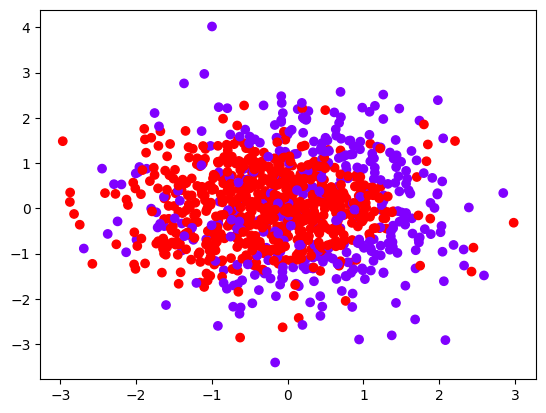

In [5]:
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='rainbow')

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, train_size=0.7)

然后构建机器学习流

In [7]:
# 构建机器学习流
pipe = make_pipeline(PolynomialFeatures(), 
                     StandardScaler(),
                       LogisticRegression(max_iter=int(1e6)))

In [8]:
# 查看参数
pipe.get_params()

{'memory': None,
 'steps': [('polynomialfeatures', PolynomialFeatures()),
  ('standardscaler', StandardScaler()),
  ('logisticregression', LogisticRegression(max_iter=1000000))],
 'verbose': False,
 'polynomialfeatures': PolynomialFeatures(),
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(max_iter=1000000),
 'polynomialfeatures__degree': 2,
 'polynomialfeatures__include_bias': True,
 'polynomialfeatures__interaction_only': False,
 'polynomialfeatures__order': 'C',
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 1000000,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2'

In [9]:
# 构造参数空间
param_grid = [
    {'PolynomialFeatures__degree': np.arange(2, 10).tolist(), 'LogisticRegression__penalty': ['l1'], 'LogisticRegression__C': np.arange(0.1, 2, 0.1).tolist(), 'LogisticRegression__solver': ['liblinear', 'saga']},
    {'PolynomialFeatures__degree':  np.arange(2, 10).tolist(), 'LogisticRegression__penalty': ['l2'], 'LogisticRegression__C': np.arange(0.1, 2, 0.1).tolist(), 'LogisticRegression__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
    {'PolynomialFeatures__degree':  np.arange(2, 10).tolist(), 'LogisticRegression__penalty': ['elasticnet'], 'LogisticRegression__C': np.arange(0.1, 2, 0.1).tolist(), 'LogisticRegression__solver': ['saga'], 'LogisticRegression__l1_ratio': np.arange(0.1, 1, 0.1).tolist()}
]

## 二、优化评估指标选取

### 1. 高级评估指标的选用方法

根据此前介绍，如果需要更好的验证模型本身泛化能力，建议使用f1-score或者roc-auc,当然调整网格搜索过程的模型评估指标过程其实并不难理解，核心就是修改scoring参数取值。但由于涉及到在参数中调用评估函数，因此需要补充一些关于常用分类评估指标在sklearn中的函数使用方法，以及不同评估指标函数在不同参数取值时在网格搜索评估器中的调用方法。

In [10]:
GridSearchCV?

Init signature:
GridSearchCV(
    estimator,
    param_grid,
    *,
    scoring=None,
    n_jobs=None,
    refit=True,
    cv=None,
    verbose=0,
    pre_dispatch='2*n_jobs',
    error_score=nan,
    return_train_score=False,
)
Docstring:     
Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.

GridSearchCV implements a "fit" and a "score" method.
It also implements "score_samples", "predict", "predict_proba",
"decision_function", "transform" and "inverse_transform" if they are
implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized
by cross-validated grid-search over a parameter grid.

Read more in the :ref:`User Guide <grid_search>`.

Parameters
----------
estimator : estimator object
    This is assumed to implement the scikit-learn estimator interface.
    Either estimator needs to provide a ``score`` function,
    or ``scoring`` must be passed.

param_grid : dict or list of

从评估器的说明文档中能够看出，scoring参数最基础的情况下可以选择输入str（字符串）或者callable（可调用）对象，也就是可以输入指代某个评估过程的字符串（一个字符串代表不同参数取值下的某评估函数），或者直接输入某评估指标函数（或者通过make_score函数创建的函数），来进行模型结果的评估。当然，也可以在该参数位上直接输入一个字典或者list,其中，如果是字典的话字典的value需要是str（字符串）或者callable（可调用）对象。这里看似复杂但实际上不难理解，由于sklearn中的评估指标函数一般都是有多个不同参数，而不同参数代表不同的计算过程，因此这些评估指标函数作为参数输入网格搜索评估器中的时候，必须通过“某种方式”确定这些参数取值，因此就有了如下方法，即通过字符串对应表来查看不同字符串所代表的不同参数取值下的评估指标函数，如下所示：

![Alt text](image-122.png)

不难看出，在网格搜索中输出评估指标参数，和调用评估指标函数进行数据处理还是有很大的区别。例如，metrics.roc_auc_score函数能够同时处理多分类问题和二分类问题，但如果作为参数输入到网格搜索中，roc_auc参数只能指代metrics.roc_auc_score函数的二分类功能，如果需要进行多分类，则需要在scoring参数中输入roc_auc_ovr、roc_auc_ovo或者roc_auc_ovr_weighted、roc_auc_ovo_weighted。我们先简单尝试在scoring中输入字符串的基本操作，然后在深入解释roc-auc评估指标的使用方法。

### 2.同时输入多组评估指标

当然，有的时候我们可能需要同时看不同参数下多项评估指标的结果，此时我们就可以在scoring中输入列表、元组或者字典，当然字典对象会较为常用，例如如果我们需要同时选用roc-auc和accuracy作为模型评估指标，则需要创建如下字典：

In [11]:
from sklearn.metrics import make_scorer

In [12]:
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

然后将参数传入机器学习流即可

不过，需要注意的是，尽管此时网格搜索评估器将同时计算一组参数下的多个评估指标结果并输出，但我们只能选取其中一个评估指标作为挑选超参数的依据，而其他指标尽管仍然会计算，但结果只作参考。而refit参数中输入的评估指标，就是最终选择参数的评估指标

尽管网格搜索支持依据不同的评估指标进行参数搜索，但最终选择何种参数，可以参考如下依据：
* 有明确模型评估指标的:

在很多竞赛或者项目算法验收环节，可能都会存在较为明确的模型评估指标，例如模型排名根据f1-sco计算结果得出等。

在该情况下，应当尽量选择要求的评估指标。
* 没有明确模型评估指标的
  
但是，如果没有明确的评估指标要求，则选择评估指标最核心的依据就是尽可能提升确保模型的泛化能力。此时，根据Lesson5中对各评估指标的讨论结果，如果数据集的各类别并没有明确的差异，在算力允许的情况下，应当优先考虑roc-auc;

而如果希望重点提升模型对类别1（或者某类别）的识别能力，则可以优先考虑F1-sco作为模型评估指标。

## 三、优化后建模流程

接下来，依据上述优化后的过程，来执行网格搜索。完整流程如下：

* 构造机器学习流

In [13]:
# 构造机器学习流
pipe = make_pipeline(PolynomialFeatures(),
                     StandardScaler(),
                     LogisticRegression(max_iter=int(1e6)))

* 构包含多个评估器的机器学习流的参数空间

In [14]:
# 构造参数空间
param_grid = [
    {'polynomialfeatures__degree': np.arange(2, 10).tolist(), 'logisticregression__penalty': ['l1'], 'logisticregression__C': np.arange(0.1, 2, 0.1).tolist(), 'logisticregression__solver': ['liblinear', 'saga']},
    {'polynomialfeatures__degree':  np.arange(2, 10).tolist(), 'logisticregression__penalty': ['l2'], 'logisticregression__C': np.arange(0.1, 2, 0.1).tolist(), 'logisticregression__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
    {'polynomialfeatures__degree':  np.arange(2, 10).tolist(), 'logisticregression__penalty': ['elasticnet'], 'logisticregression__C': np.arange(0.1, 2, 0.1).tolist(), 'logisticregression__solver': ['saga'], 'logisticregression__l1_ratio': np.arange(0.1, 1, 0.1).tolist()}
]

* 实例化网格搜索评估器

考虑到实际参数空间较大，网格搜索需要耗费较长时间，此次使用单一指标roc作为参数选取指标进行搜索：

In [15]:
search = GridSearchCV(pipe, param_grid, scoring='roc_auc', n_jobs=5)

* 执行训练

In [16]:
search.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000000))]),
             n_jobs=5,
             param_grid=[{'logisticregression__C': [0.1, 0.2,
                                                    0.30000000000000004, 0.4,
                                                    0.5, 0.6,
                                                    0.7000000000000001, 0.8,
                                                    0.9, 1.0, 1.1,
                                                    1.2000000000000002,
                                                    1.3000000000000003,
                                                    1.4000000...
                                                    1.4000000000000001,
                                                    1.5000000000000002, 1.6,
                                                    1.7000000000000002,
                                                    1.8000000000000003,
                                                    1.9000000000000001],
                          'logisticregression__l1_ratio': [0.1, 0.2,
                                                           0.30000000000000004,
                                                           0.4, 0.5, 0.6,
                                                           0.7000000000000001,
                                                           0.8, 0.9],
                          'logisticregression__penalty': ['elasticnet'],
                          'logisticregression__solver': ['saga'],
                          'polynomialfeatures__degree': [2, 3, 4, 5, 6, 7, 8,
                                                         9]}],
             scoring='roc_auc')

* 查看结果

In [17]:
search.best_score_

0.7881621972398326

In [18]:
search.best_params_

{'logisticregression__C': 0.2,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'liblinear',
 'polynomialfeatures__degree': 3}

需要注意的是，上述best_score属性查看的结果是在roc-auc评估指标下，默认五折交叉验证时验证集上的roc-auc的平均值，但如果我们对训练好的评估器使用socre方法，查看的仍然是pipe评估器默认的结果评估方式，也就是准确率计算结果：

In [19]:
search.best_estimator_.score(x_train, y_train)

0.7857142857142857

In [20]:
search.best_estimator_.score(x_test, y_test)

0.78

* 结果分析

最终模型结果准确率在78%上下。当然，如果只看模型准确率结果，我们发现该结果相比Lesson6,4中结果较差（Lesson6.4中测试集最高得分达到0.8)。但是，该模型相比Lesson6.4中模型来看，该模型基本没有过拟合隐患（测试集分数甚至高于训练集），因此该模型在未来的使用过程中更有可能能够确保一个稳定的预测输出结果（泛化能力更强）。这也是交叉验证和roc-auc共同作用的结果。

当然，如果有明确要求根据准确率判断模型效果，则上述过程应该选择准确率，同时如果算力允许，也可以近一步扩大搜索空间(Lesson6.4中0.8的准确率就是在15阶多项式特征衍生基础上进行的运算)。

至此，我们就完成了在实验数据上的建模调优，在下一小节，我们将把上述技巧应用到一项kaggle数据集上来进行建模分析，届时我们还将补充更多实战过程中会用到的方法和技巧。